In [76]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd

# Read dataset off Github
ml_hs_2017_all = pd.read_csv("https://github.com/jakemdrew/EducationDataNC/raw/master/2017/Machine%20Learning%20Datasets/PublicHighSchools2017_ML.csv")

# creating categorical variable from existing column - https://stackoverflow.com/a/49269107
ml_hs_2017_all.loc[ml_hs_2017_all['sat_avg_score_num'] < 1080,'sat_high_level'] = 0
ml_hs_2017_all.loc[ml_hs_2017_all['sat_avg_score_num'] >= 1080,'sat_high_level'] = 1

# subsetting to remove rows where no average SAT score was reported
ml_hs_2017 = ml_hs_2017_all.loc[ml_hs_2017_all['sat_avg_score_num'] >0]

In [77]:
zero_counts = []
for column in ml_hs_2017:
    zero_counts.append({'Column': column, 'count': np.sum((ml_hs_2017[column]==0)), 'Percentage': np.sum((ml_hs_2017[column]==0)/len(ml_hs_2017))})

In [78]:
zero_counts = pd.DataFrame(zero_counts)
to_drop = zero_counts.loc[zero_counts['Percentage'] >= .999]
hs_2017 = ml_hs_2017.drop(to_drop['Column'], axis=1)

In [79]:
# derive the absolute pearson's r for correlation, convert to dataframe

abs_correlation_ml_final = hs_2017.corr(method='pearson').abs()
abs_correlation_ml_final = pd.DataFrame(abs_correlation_ml_final)

In [81]:
sat_correlation = abs_correlation_ml_final.sort_values(by='sat_high_level',ascending=False)
hs_2017_sat_high = sat_correlation.loc[sat_correlation['sat_high_level'] >= 0.10]
hs_2017_sat_high = hs_2017_sat_high[['sat_high_level']]
# hs_2017_sat_high.to_csv(path_or_buf='./hs_2017_sat_high.csv')
hs_2017 = hs_2017[['sat_high_level','sat_avg_score_num','ACTMath_ACTBenchmark_All','ACTScience_ACTBenchmark_All','ACTMath_ACTBenchmark_Female','ACTScience_ACTBenchmark_Female','ACTReading_ACTBenchmark_Female','ACTEnglish_ACTBenchmark_Female','ACTMath_ACTBenchmark_Male','ACTScience_ACTBenchmark_Male','ACT Score','Gr_9_Pct_Prof','ACTCompositeScore_UNCMin_Female','ACTWriting_ACTBenchmark_All','EOCSubjects_CACR_All','ACTMath_ACTBenchmark_White','SPG Score','EOCMathI_CACR_Male','ACTSubtests_BenchmarksMet_White','ACTScience_ACTBenchmark_White','ACTCompositeScore_UNCMin_Male','pct_eds','lea_sat_avg_score_num','NC Math 1 Score','EOCEnglish2_CACR_Female','EOCEnglish2_CACR_Male','EOCSubjects_CACR_White','ACTWriting_ACTBenchmark_Male','ACTSubtests_BenchmarksMet_EDS','EOCMathI_CACR_White','ACTSubtests_BenchmarksMet_AIG','EOCBiology_CACR_Female','ACTWriting_ACTBenchmark_White','English II Score','ACTScience_ACTBenchmark_AIG','ACTScience_ACTBenchmark_EDS','ACTSubtests_BenchmarksMet_Hispanic','Biology Score','EOCBiology_CACR_Male','EOCEnglish2_CACR_White','ACTMath_ACTBenchmark_EDS','4-Year Cohort Graduation Rate Score','ACTCompositeScore_UNCMin_White','EOCSubjects_CACR_EDS','ACTWriting_ACTBenchmark_AIG','lea_ap_pct_3_or_above','ACTReading_ACTBenchmark_EDS','EOCSubjects_CACR_Hispanic','MW_White_ENROLL_sch_pct','BlackPct','EOCBiology_CACR_White','ACTWriting_ACTBenchmark_EDS','EOCMathI_CACR_EDS','ACTSubtests_BenchmarksMet_Asian','ACTEnglish_ACTBenchmark_EDS','BlackMalePct','ap_pct_3_or_above','short_susp_per_c_num','Proficient_TCHR_Standard 4_Pct','MinorityPct','ACTMath_ACTBenchmark_AIG','ACTCompositeScore_UNCMin_EDS','MinorityMalePct','SPG Grade_C','lateral_teach_pct','ACTSubtests_BenchmarksMet_TwoorMoreRaces','avg_daily_attend_pct','lea_federal_perpupil_num','Proficient_TCHR_Standard 1_Pct','BlackFemalePct','EOCEnglish2_CACR_EDS','flicensed_teach_pct','ACTSubtests_BenchmarksMet_Black','Proficient_TCHR_Standard 2_Pct','lea_salary_expense_pct','ACTScience_ACTBenchmark_Hispanic','lea_flicensed_teach_pct','lea_nbpts_num','advance_dgr_pct','lea_short_susp_per_c_num','EOCSubjects_CACR_Asian','lea_ap_participation_pct','lea_advance_dgr_pct','ACTWriting_ACTBenchmark_Hispanic','Proficient_TCHR_Standard 3_Pct','Proficient_TCHR_Standard 5_Pct','ACTMath_ACTBenchmark_Hispanic','Exceeds Expected Growth_TCHR_Student Growth_Pct','Does Not Meet Expected Growth_TCHR_Student Growth_Pct','EOCBiology_CACR_Asian','ACTReading_ACTBenchmark_Hispanic','EOCEnglish2_CACR_Asian','MinorityFemalePct','ACTSubtests_BenchmarksMet_SWD','nbpts_num','MB_Black_ENROLL_sch_pct','ap_participation_pct','AsianFemalePct','cte_courses','Accomplished_TCHR_Standard 4_Pct','EOCBiology_CACR_EDS','Accomplished_TCHR_Standard 5_Pct','ACTEnglish_ACTBenchmark_Hispanic','ACTWriting_ACTBenchmark_Asian','ACTScience_ACTBenchmark_Black','ACTEnglish_ACTBenchmark_SWD','Accomplished_TCHR_Standard 2_Pct','ACTCompositeScore_UNCMin_SWD','ACTCompositeScore_UNCMin_Asian','AsianMalePct','EOCMathI_CACR_Hispanic','ACTReading_ACTBenchmark_SWD','lea_supplies_expense_pct','EOCMathI_CACR_Asian','Accomplished_TCHR_Standard 1_Pct','ALL_All Students (Total or Subtotal_ENROLL_sch_pct','ACTScience_ACTBenchmark_SWD','ACTMath_ACTBenchmark_SWD','GraduationRate_4yr_Male','GraduationRate_4yr_Asian','M_Male_ENROLL_sch_pct','State Gap Compared_Y','tchyrs_0thru3_pct','GraduationRate_4yr_Female','lea_state_perpupil_num','GraduationRate_5yr_Asian','Accomplished_TCHR_Standard 3_Pct','GraduationRate_4yr_White','EOCSubjects_CACR_Black','lea_tchyrs_0thru3_pct','lea_avg_daily_attend_pct','ACTMath_ACTBenchmark_Black','EOCEnglish2_CACR_Hispanic','EOCSubjects_CACR_AIG','ACTScience_ACTBenchmark_TwoorMoreRaces','ACTMath_ACTBenchmark_TwoorMoreRaces','GraduationRate_5yr_White','EOCBiology_CACR_TwoorMoreRaces','lea_local_perpupil_num','EOCMathI_CACR_AIG','EOCMathI_CACR_TwoorMoreRaces','lea_1yr_tchr_trnovr_pct','Distinguished_TCHR_Standard 4_Pct','ACTWriting_ACTBenchmark_SWD','ACTWorkKeys_SilverPlus_Black','EOCBiology_CACR_Hispanic','ACTCompositeScore_UNCMin_Hispanic','EOCBiology_CACR_AIG','SPG Grade_A+NG','EOCSubjects_CACR_TwoorMoreRaces','ACTWriting_ACTBenchmark_TwoorMoreRaces','EOCMathI_CACR_SWD','Distinguished_TCHR_Standard 1_Pct','EVAAS Growth Status_NotMet','GraduationRate_4yr_Black','SPG Grade_B','ACTReading_ACTBenchmark_Black','SPG Grade_D','lea_avg_student_num','_1yr_tchr_trnovr_pct','EOG/EOCSubjects_CACR_SWD','GraduationRate_5yr_All','EOCEnglish2_CACR_SWD','lea_books_per_student','ACTWriting_ACTBenchmark_Black','GraduationRate_5yr_Black','lea_instruct_equip_exp_pct','lea_services_expense_pct','EOCSubjects_CACR_SWD','ACTReading_ACTBenchmark_TwoorMoreRaces','F_Female_ENROLL_sch_pct','EOCEnglish2_CACR_AIG','univ_college_courses','Distinguished_TCHR_Standard 3_Pct','GraduationRate_5yr_Female','ACTCompositeScore_UNCMin_AIG','EOCEnglish2_CACR_TwoorMoreRaces','Distinguished_TCHR_Standard 2_Pct','EOCMathI_GLP_SWD','EOG/EOCSubjects_GLP_SWD','SBE District_Northeast','Developing_TCHR_Standard 1_Pct','Developing_TCHR_Standard 5_Pct','lea_wap_per_classroom','EOCEnglish2_GLP_SWD','10+ Years_LEA_Exp_Pct_Prin','ACTCompositeScore_UNCMin_TwoorMoreRaces','lea_tchyrs_11plus_pct','lea_cte_courses','grade_range_cd_9-13','ACTWorkKeys_SilverPlus_Hispanic','AGNR_Concentrator_Ct','ACTSubtests_BenchmarksMet_LEP','EOCSubjects_GLP_SWD','SBE District_Northwest','ACTWorkKeys_SilverPlus_EDS','EVAAS Growth Score','avg_age_media_collection','GraduationRate_4yr_AIG','EOCMathI_CACR_LEP','EOCBiology_CACR_SWD','EOCSubjects_CACR_LEP','tchyrs_11plus_pct','Byod_Yes','grades_BYOD_9:10:11:12:13','SBE District_Western','ACTEnglish_ACTBenchmark_Black','GraduationRate_5yr_Male','Developing_TCHR_Standard 4_Pct','calendar_type_txt_Regular School, Year-Round Calendar','Distinguished_TCHR_Standard 5_Pct','student_num','crime_per_c_num','lea_total_expense_num','EOCMathI_CACR_Black','Developing_TCHR_Standard 3_Pct','English II_Size','12_Size','0-3 Years_LEA_Exp_Pct_Prin','grade_range_cd_9-12','lea_stud_internet_comp_num','Developing_TCHR_Standard 2_Pct','HispanicMalePct','EOCEnglish2_CACR_LEP','EOCEnglish2_CACR_Black','EOCBiology_CACR_AmericanIndian','ACT_pTarget_PctMet','EOCBiology_GLP_SWD','esea_status_P','SBE District_Sandhills','GraduationRate_4yr_AmericanIndian','ACTCompositeScore_UNCMin_AmericanIndian','SRC_Grades_Devices_Sent_Home_9:10:11:12:13','lea_tchyrs_4thru10_pct','EOCEnglish2_CACR_AmericanIndian','long_susp_per_c_num','ACTWorkKeys_SilverPlus_AmericanIndian','11_Size','grades_1_to_1_access_9:10:11:12:13','tchyrs_4thru10_pct','lea_long_susp_per_c_num','IndianFemalePct','EOCMathI_GLP_LEP','EOCSubjects_GLP_LEP','GraduationRate_4yr_TwoorMoreRaces','EOCEnglish2_GLP_LEP','EOG/EOCSubjects_GLP_LEP','TwoOrMoreFemalePct','GraduationRate_5yr_AmericanIndian','ACTWriting_ACTBenchmark_AmericanIndian','TotalTargets_pTarget_PctMet','grade_range_cd_6-13','ACTWorkKeys_SilverPlus_Asian','Biology_Size','HispanicPct','ACTScience_ACTBenchmark_LEP','ACTEnglish_ACTBenchmark_LEP','EOCBiology_CACR_Black']]
hs_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 469
Columns: 258 entries, sat_high_level to EOCBiology_CACR_Black
dtypes: float64(239), int64(19)
memory usage: 851.9 KB


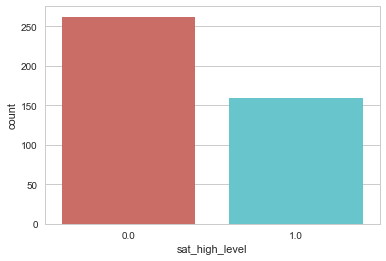

In [82]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

sns.countplot(x='sat_high_level',data=hs_2017, palette='hls')
plt.show()

In [83]:
# logistic regression steps from

X = hs_2017.iloc[:,1:]
y = hs_2017.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [84]:
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [85]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[47  4]
 [ 8 26]]


In [86]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.86


In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, cross_validation

predicted = cross_validation.cross_val_predict(LogisticRegression(), X_train, y_train, cv=10)
print('Accuracy of 10-fold cross-validated logistic regression classifier on test set:',metrics.accuracy_score(y_train, predicted))
print('\n',metrics.classification_report(y_train, predicted))

Accuracy of 10-fold cross-validated logistic regression classifier on test set: 0.8779761904761905

              precision    recall  f1-score   support

        0.0       0.91      0.89      0.90       211
        1.0       0.82      0.86      0.84       125

avg / total       0.88      0.88      0.88       336

